In [5]:
from models import *
from load import *
from torch import Tensor, nn
import torch
from models_base import Dataset, get_device
from modules import NormalizedPoissonRMSE, PoissonVAE

ROOT = "./Datas/Week 7"

class Progress:
    def __init__(self, pad = 200):
        self.pad = pad
    
    def rint(self, content: str):
        print(content.ljust(self.pad), end = '\r')
        self.pad = max(self.pad, len(content) + 1)

Q = 1.60217663e-19

def init_weights(m):
    try:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    except AttributeError:
        pass

def load():
    ep = Dataset(load_elec_potential())
    sc = Dataset(load_space_charge() * (-Q))
    epsc = (ep + sc).clone().to_tensor().reshape(-1, 4386)
    return epsc

def train(epochs: int, latent: int = 5):
    noise_ = 0.01
    device = get_device()
    net = PoissonVAE(latent).to(device).double()
    net.apply(init_weights)
    history = []
    mse = nn.MSELoss()
    poi = NormalizedPoissonRMSE()
    epsc = load().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
    p = Progress()

    for epoch in range(epochs):
        # Add some noise
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()

            x = epsc
            noisy_x = x + (torch.rand((1, 4386)) - 1/2).to(device).double() * noise_
            x_hat = net(noisy_x)
            mse_loss_ep = mse(x[:, :2193], x_hat[:, :2193])
            mse_loss_sc = mse(x[:, 2193:], x_hat[:, 2193:])
            poi_loss = poi(x_hat[:, :2193], x_hat[:, 2193:])
            kl_diver = net.get_kl_divergence()
            loss = mse_loss_ep + mse_loss_sc + poi_loss + kl_diver
            if loss.requires_grad:
                loss.backward()

            nonlocal history
            history.append([mse_loss_ep.item(), mse_loss_sc.item(), poi_loss.item(), kl_diver.item()])

            nonlocal p
            mse1_, mse2_, poi_, kl_ = history[-1]
            p.rint(f"Elapsed {epoch} epochs with MSE: {mse1_:.7f}, {mse2_:.7f}, Poisson: {poi_:.7f}, KL divergence: {kl_:.7f}")

            return loss
        optimizer.step(closure)

        _, _, poi_, kl_ = history[-1]
        if poi_ < 0.01 and kl_ < 0.01:
            break
    return net, history

net, history = train(999999)

KeyboardInterrupt: 

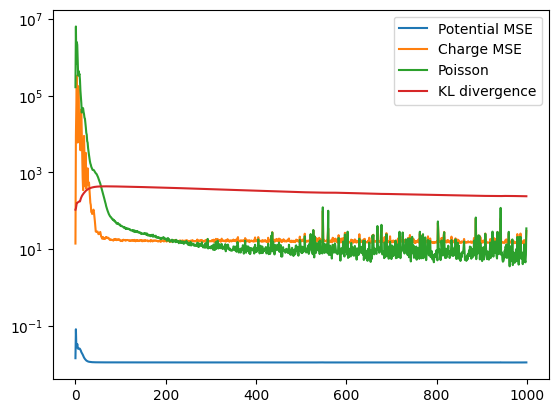

In [4]:
from anim import make_anim
from load import *
from models_base import Dataset
import matplotlib.pyplot as plt
from torchsummary import summary
import subprocess

def save_stuff(net, history, training_model_no: int, nocommit: bool = True):
    # Animation
    Q = 1.60217663e-19
    ep = Dataset(load_elec_potential())
    sc = Dataset(load_space_charge() * (-Q))
    x = (ep + sc).clone().to_tensor().reshape(-1, 4386).to('cuda')
    net = net.to('cuda')

    root = f"{ROOT}/VAE model {training_model_no}"
    
    with torch.no_grad():
        y = net(x)
        y_ep = y[:, :2193].reshape(-1, 129, 17).cpu().numpy()
        y_sc = y[:, 2193:].reshape(-1, 129, 17).cpu().numpy()
        ep = load_elec_potential().cpu().numpy()
        sc = load_space_charge().cpu().numpy() * -Q
        make_anim(y_ep, ep, f"{root}/potential.gif", "Potential")
        make_anim(y_sc, sc, f"{root}/sc.gif", "Space charge")

    # Graph 
    plt.figure()
    plt.plot(history)
    plt.yscale('log')
    plt.legend(["Potential MSE", "Charge MSE", "Poisson", "KL divergence"])
    plt.savefig(f"{root}/model history.png")

    # Model
    torch.save(net, f"{root}/model.pt")

    # Structure
    commit_token = f"Saved model VAE model {training_model_no}"
    with open(f"{root}/logs.txt", 'w', encoding='utf-8') as f:
        f.write("Model structure:\n\n")
        f.write(f"{summary(net, verbose=0)}")
        f.write("\n\n")
        f.write(f"Save at the commit \"{commit_token}\"")
    
    # Make a git commit to save the code
    if not nocommit:
        subprocess.call(["git", "add", "."])
        subprocess.call(["git", "commit", "-m", commit_token])
        subprocess.call(["git", "push", "origin", "master"])

save_stuff(net, history, 1)